# YOLOv8n

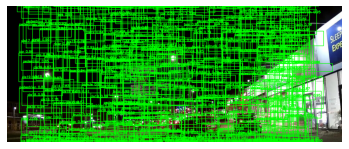

In [1]:
import cv2
import numpy as np
import vart
import xir
import matplotlib.pyplot as plt

# =========================
# CONFIGURATION
# =========================
XM_MODEL = "yolov8n.xmodel"
IMAGE_PATH = "2.jpg"
IMG_SIZE = 640
NUM_CLASSES = 13
CLASS_NAMES = [
    'pedestrian','rider','car','bus','truck',
    'bicycle','motorcycle','green light','red light',
    'yellow light','traffic light','traffic sign','train'
]

CONF_THRESH = 0.25
IOU_THRESH = 0.45


# =========================
# Helper functions
# =========================
def preprocess(img_path, size=640):
    img = cv2.imread(img_path)
    h0, w0 = img.shape[:2]
    r = size / max(h0, w0)
    new_unpad = (int(w0 * r), int(h0 * r))
    img_resized = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)

    dw, dh = size - new_unpad[0], size - new_unpad[1]
    dw /= 2
    dh /= 2
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img_padded = cv2.copyMakeBorder(img_resized, top, bottom, left, right,
                                    cv2.BORDER_CONSTANT, value=(114,114,114))
    img_in = img_padded[:, :, ::-1].astype(np.float32) / 255.0  # BGR->RGB
    img_in = np.transpose(img_in, (2,0,1))  # CHW
    return np.expand_dims(img_in, 0), img, (h0, w0), (dw, dh), r


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def softmax(x, axis=-1):
    e = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e / np.sum(e, axis=axis, keepdims=True)


def nms(boxes, scores, iou_threshold=0.5):
    if len(boxes) == 0:
        return []
    boxes = boxes.astype(float)
    x1, y1, x2, y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        iou = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(iou <= iou_threshold)[0]
        order = order[inds + 1]
    return keep


# =========================
# YOLOv8 decoding (with DFL)
# =========================
def decode_outputs(outputs, orig_shape, pad, gain,
                   conf_thresh=0.25, iou_thresh=0.45):
    strides = [8,16,32]
    no = NUM_CLASSES + 4
    dfl_ch = outputs[0].shape[1] - no
    reg_max = dfl_ch // 4

    preds = []
    for out, stride in zip(outputs, strides):
        bs, c, h, w = out.shape
        out = out.transpose(0,2,3,1).reshape(bs,-1,c)
        preds.append(out)
    pred = np.concatenate(preds, 1)[0]

    box_distr, cls_pred = np.split(pred, (reg_max*4,), axis=1)
    cls_pred = sigmoid(cls_pred)

    box_distr = box_distr.reshape(-1,4,reg_max)
    dfl = softmax(box_distr, axis=2)
    proj = np.arange(reg_max, dtype=np.float32)
    box = np.sum(dfl * proj, axis=2)

    N = box.shape[0]
    grids = []
    for stride, out in zip(strides, outputs):
        _,_,h,w = out.shape
        yv,xv = np.meshgrid(np.arange(h), np.arange(w))
        grid = np.stack((xv,yv),2).reshape(-1,2)
        grids.append(grid)
    grid = np.concatenate(grids,0)

    strides_all = np.concatenate([np.full((g.shape[0],1), s)
                                  for g,s in zip(grids,strides)],0)

    xy = (box[:,:2] + grid) * strides_all
    wh = (box[:,2:] ) * strides_all
    boxes = np.concatenate((xy - wh/2, xy + wh/2),1)

    scores = cls_pred.max(1)
    cls_ids = cls_pred.argmax(1)

    mask = scores > conf_thresh
    boxes, scores, cls_ids = boxes[mask], scores[mask], cls_ids[mask]

    boxes[:,[0,2]] -= pad[0]
    boxes[:,[1,3]] -= pad[1]
    boxes /= gain
    h0,w0 = orig_shape
    boxes[:,0::2] = boxes[:,0::2].clip(0,w0)
    boxes[:,1::2] = boxes[:,1::2].clip(0,h0)

    if len(boxes)==0:
        return []
    keep = nms(boxes, scores, iou_thresh)
    return [(boxes[i], scores[i], int(cls_ids[i])) for i in keep]


# =========================
# Run on DPU
# =========================
def run_xmodel(xmodel_path, input_tensor):
    g = xir.Graph.deserialize(xmodel_path)
    subgraphs = [sg for sg in g.get_root_subgraph().toposort_child_subgraph()
                 if sg.has_attr("device") and sg.get_attr("device").upper()=="DPU"]
    runner = vart.Runner.create_runner(subgraphs[0], "run")

    inputTensors = runner.get_input_tensors()
    outputTensors = runner.get_output_tensors()

    inputShape = tuple(inputTensors[0].dims)
    outputShapes = [tuple(t.dims) for t in outputTensors]

    inputData = [np.empty(inputShape, dtype=np.float32, order="C")]
    outputData = [np.empty(s, dtype=np.float32, order="C") for s in outputShapes]

    # CHW -> HWC
    inputData[0][0,...] = np.transpose(input_tensor[0], (1,2,0))

    job_id = runner.execute_async(inputData, outputData)
    runner.wait(job_id)
    return outputData


# =========================
# Main
# =========================
if __name__ == "__main__":
    img_in, orig, orig_shape, pad, gain = preprocess(IMAGE_PATH, IMG_SIZE)

    outputs = run_xmodel(XM_MODEL, img_in)
    dets = decode_outputs(outputs, orig_shape, pad, gain, CONF_THRESH, IOU_THRESH)

    for box, score, cls in dets:
        x1,y1,x2,y2 = box.astype(int)
        cv2.rectangle(orig, (x1,y1), (x2,y2), (0,255,0), 2)
        if 0 <= cls < len(CLASS_NAMES):
            label = f"{CLASS_NAMES[cls]} {score:.2f}"
        else:
            label = f"cls{cls} {score:.2f}"
        cv2.putText(orig, label, (x1, y1-2),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
